### Distinguish images of dogs from cats
[Kaggle competiton](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)  
  
Import [fastai](https://docs.fast.ai/) (sits on top of [PyTorch](https://pytorch.org/))

In [1]:
import matplotlib.image as img
from fastai import *
from fastai.vision import *
%matplotlib inline

### View raw data

In [2]:
path = 'data/'
os.listdir(path)

['sample_submission.csv',
 'test',
 'submission_01.csv',
 'valid',
 'models',
 'train']

In [3]:
cats = os.listdir(f'{path}/train/cat')
dogs = os.listdir(f'{path}/train/dog')
cats[:3]

['cat.2648.jpg', 'cat.6224.jpg', 'cat.11264.jpg']

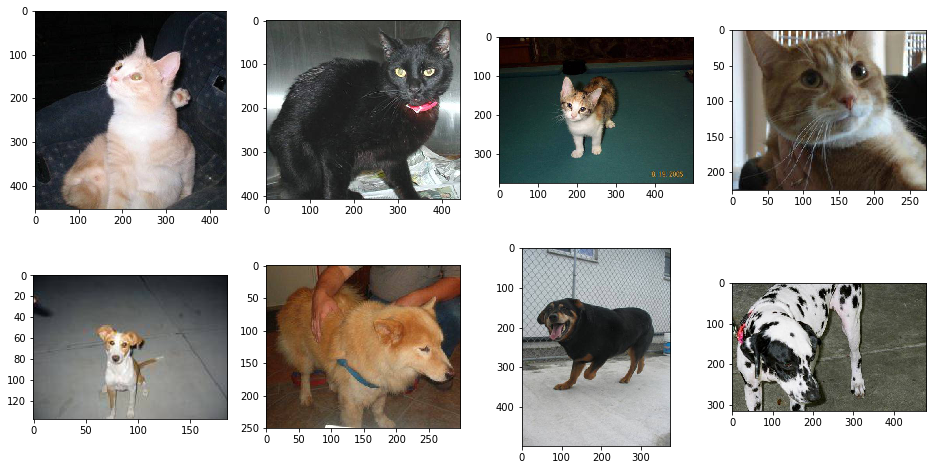

In [4]:
_, ax = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    ax[0][i].imshow(img.imread(f'{path}train/cat/{cats[i]}'))
    ax[1][i].imshow(img.imread(f'{path}train/dog/{dogs[i]}'))

### Split Train, Test, Validation set 
It's allready done, ignore it!

#move files to 'valid' folders
for group in ['cat', 'dog']:
    group_path = f'{path}train/{group}/'
    group_files = os.listdir(group_path)
    group_len = len(group_files)
    to_move = random.sample(range(group_len), int(group_len/5))
    for idx in to_move:
        file_name = group_files[idx]
        shutil.move(f'{group_path}{file_name}', f'{path}valid/{group}/{file_name}')

### Data augmentation

Instead of feeding the model with the same pictures every time, we do small random transformations (a bit of rotation, zoom, translation, etc...) that don't change what's inside the image (for the human eye) but change its pixel values. Models trained with data augmentation will then generalize better.

We are going to use fastai default values: do_flip=True, flip_vert=False, max_rotate=10, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75 

More info: https://docs.fast.ai/vision.transform.html#get_transforms

In [5]:
my_tfms = get_transforms()
my_size = 128 # my_size x my_size is input picture resolution

#### Visualize data augmentation

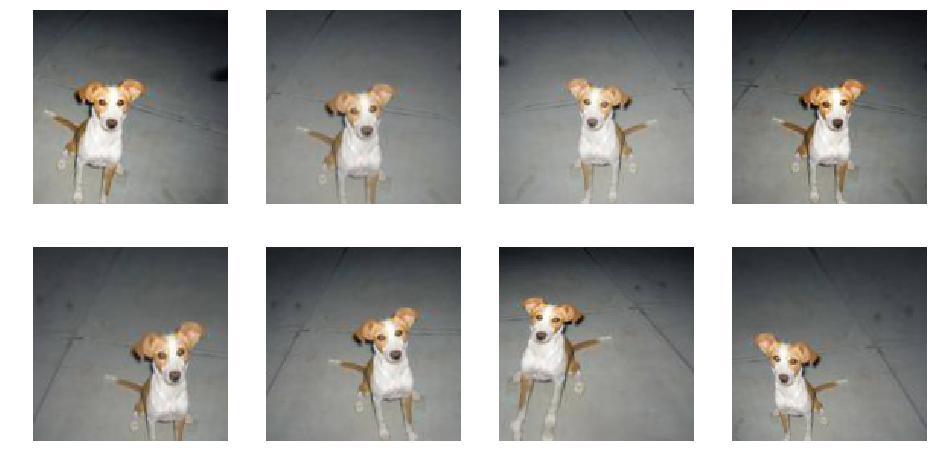

In [6]:
def get_ex(): return open_image(f'{path}/train/dog/{dogs[0]}')

def plots_f(rows, cols, width, height, **kwargs):
    [apply_tfms(my_tfms[0], get_ex(), **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

plots_f(2, 4, 16, 8, size=my_size)

### Make data
Bind together a train, a valid and test pictures and apply to them data augmentation as batch are drawn.

In [7]:
data = ImageDataBunch.from_folder(path, ds_tfms=my_tfms, size=my_size, test='test').normalize(imagenet_stats)

#### Count pictures and display random cats and dogs

Number of pictures
Train cats: 10000
Train dogs: 10000
Valid cats:  2500
Valid dogs:  2500
Test pics:  12500
Total pics: 37500


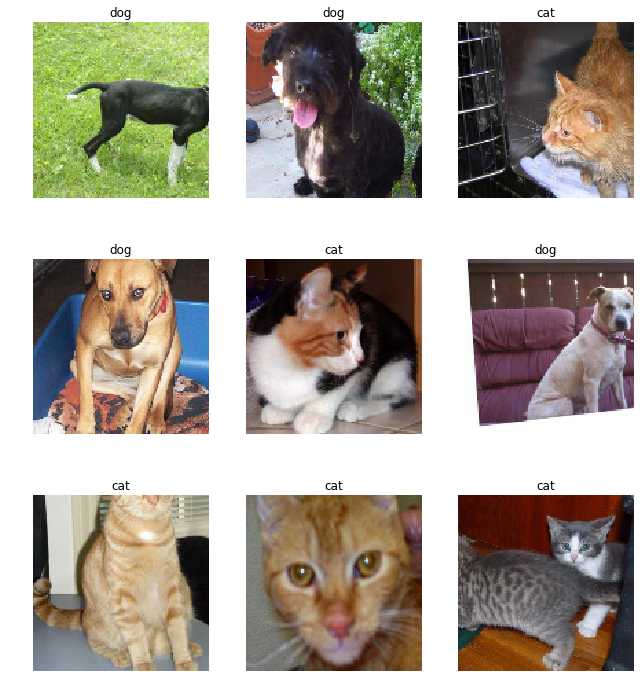

In [8]:
print('Number of pictures')
print('Train cats:', sum(data.train_ds.ds.y == 0))
print('Train dogs:', sum(data.train_ds.ds.y == 1))
print('Valid cats: ', sum(data.valid_ds.ds.y == 0))
print('Valid dogs: ', sum(data.valid_ds.ds.y == 1))
print('Test pics: ', len(data.test_ds))
print('Total pics:', len(data.train_ds) + len(data.valid_ds) + len(data.test_ds))

data.show_batch(rows=3)

### Load a pretrained PyTourch model 
ready for fine tuning

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

Learning rate finder (learn.lr_find) will increase the learning rate after each mini-batch. Eventually, the learning rate is too high that loss will get worse. We then look at the plot of learning rate against loss, and determine the lowest point and go back by one magnitude and choose that as a learning rate.

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.fit(2, lr=0.005)

### Alternatively we can use Leslie Smith's [1cycle policy](https://sgugger.github.io/the-1cycle-policy.html).

In [14]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.fit_one_cycle(2)

Total time: 01:57
epoch  train_loss  valid_loss  accuracy
1      0.094821    0.053764    0.979600  (00:58)
2      0.057954    0.040475    0.983800  (00:58)



#### Visualize learning rate and momentum change over time

In [ ]:
learn.recorder.plot_lr(show_moms=True)

### Should we train earlier pretrained layers?
Unfreeze entire model - sets every layer group to trainable.

In [15]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,3e-4))

Total time: 05:07
epoch  train_loss  valid_loss  accuracy
1      0.054220    0.043968    0.983600  (01:16)
2      0.061868    0.034790    0.986800  (01:16)
3      0.028613    0.035215    0.987800  (01:16)
4      0.020384    0.030260    0.989200  (01:16)



TODO: Problem: train_loss < valid_loss = overfitting

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)
interp.plot_confusion_matrix()

### Should we use TTA?
TTA = Test Time Augmentation.  
Kaggle submissions are scored on the log loss:

In [16]:
def get_logloss(preds):
    total = 0
    data_len = len(preds[0])
    
    for i in range(data_len):
        is_dog = preds[1][i].item()
        dog_probability = preds[0][i][1].item()
        if is_dog:
            total += log(dog_probability)
        else:
            total += log(1-dog_probability)

    return -total/data_len

In [17]:
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
valid_TTA = learn.TTA(ds_type=DatasetType.Valid)
get_logloss(valid_preds), get_logloss(valid_TTA)

Total time: 01:09



(0.03026034172221598, 0.03433448101375135)

#### A smaller log loss is better. TTA doesn't improve results.

TODO: double the image resolution, use resnet101 and train with valid data as well

### Make prediction

In [ ]:
test_preds = learn.get_preds(ds_type=DatasetType.Test)
test_preds

In [ ]:
result = pd.DataFrame(to_np(test_preds[0]), columns=data.classes)

result.index = data.test_ds.ds.x.astype(str)
result.index = result.index.str.strip('data/test/')
result.index = result.index.str.strip('.jpg')
result.index = result.index.map(int)
result.index.name = 'id'

result = result.drop(columns='cat')
result = result.rename(columns = {'dog':'label'})
result.sort_index(inplace=True)

result[:6]

In [ ]:
result.to_csv('~/DogsVsCats/data/submission_01.csv')
!head -7 ~/DogsVsCats/data/submission_01.csv

In [ ]:
_, ax = plt.subplots(1,6, figsize=(16, 8))

for i in range(6):
    fname = f'{path}test/{i+1}.jpg'
    print(fname)
    ax[i].imshow(img.imread(fname))

TODO: Submit to kaggle

Notes

(model, batch size)(learning rate, number of cycles) - train loss, validation loss, accuracy
(resnet18,  64)(0.01, 2) - 0.317192   0.275304   0.8766  
(resnet34,  64)(0.01, 2) - 0.290045   0.259357   0.8862  
(resnet50,  64)(0.01, 2) - 0.217489   0.198424   0.9094 <-- default
(resnet101, 64)(0.01, 2) - 0.225131   0.197778   0.9200   
(resnet152, 64)(0.01, 2) - 0.220984   0.198254   0.9142  
(vgg16,     64)(0.01, 2) - 0.217524   0.17935    0.9260  
(vgg19,     64)(0.01, 2) - 0.218113   0.182801   0.9228  

different resnet50:
(resnet50,  32)(0.01, 2) - 0.47635    0.452985   0.7850  
(resnet50,  64)(0.001,2) - 0.235529   0.202365   0.9108  
(resnet50,  64)(0.01, 2) - 0.217489   0.198424   0.9094 <-- default
(resnet50,  64)(0.01, 2) - 0.209568   0.194419   0.9166 aug_tfms=transforms_side_on, max_zoom=1.1 
(resnet50,  64)(0.1,  2) - 0.236555   0.197519   0.9182   
(resnet50, 128)(0.01, 2) - 0.065976   0.043656   0.9856 
(resnet50, 256)(0.01, 2) - 0.029497   0.022395   0.9926 